<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [ ]:
import os, cv2, glob
import numpy as np
import pandas as pd

'''
If you want to know this file,
refer to https://github.com/smupilab/Trajectory-AE/blob/master/utils/convertImage.py
'''
from drive.MyDrive.University.PiLab.Experiment.Codes import convertImage as utils

In [ ]:
os.getcwd()

'/content'

# Set Constants

In [ ]:
# Constants
WIDTH, HEIGHT = 256, 256

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '6',
    'date' : '03-22-2021',
    'description' : 'Image Augmentation using crop\n'
    }

ROOT_DIR = os.path.join('/content', 'drive','MyDrive','University','PiLab','Experiment' )
DATA_DIR = os.path.join( ROOT_DIR, 'Data', 'Trajectory_virtual_data')
RESULT_DIR = os.path.join( ROOT_DIR, 'Results')

# Load and Preprocessing Data

## Convert CSV to Image

In [ ]:
os.chdir( DATA_DIR )

files = glob.glob( '*csv' )

generator = utils.Map2ImageGenerator( WIDTH, HEIGHT, 0 )

images = [ ]
for file in files:
    csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )

    images.append( generator.ConvertImage( csv_file ) )

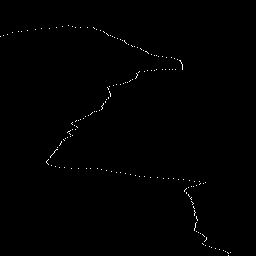

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow( images[0] )

## Crop Image

In [ ]:
CROP_WIDTH, CROP_HEIGHT = 32, 32

cropped_images = [ ]
for image in images:
    for i in range( 0, HEIGHT, CROP_HEIGHT ):
        for j in range( 0, WIDTH, CROP_WIDTH ):
            curr_image = [ ]
            for ii in range( i, i + CROP_HEIGHT ):
                curr_image.append( image[ii][j : j + CROP_WIDTH] )
            cropped_images.append( curr_image )

<Figure size 432x288 with 0 Axes>

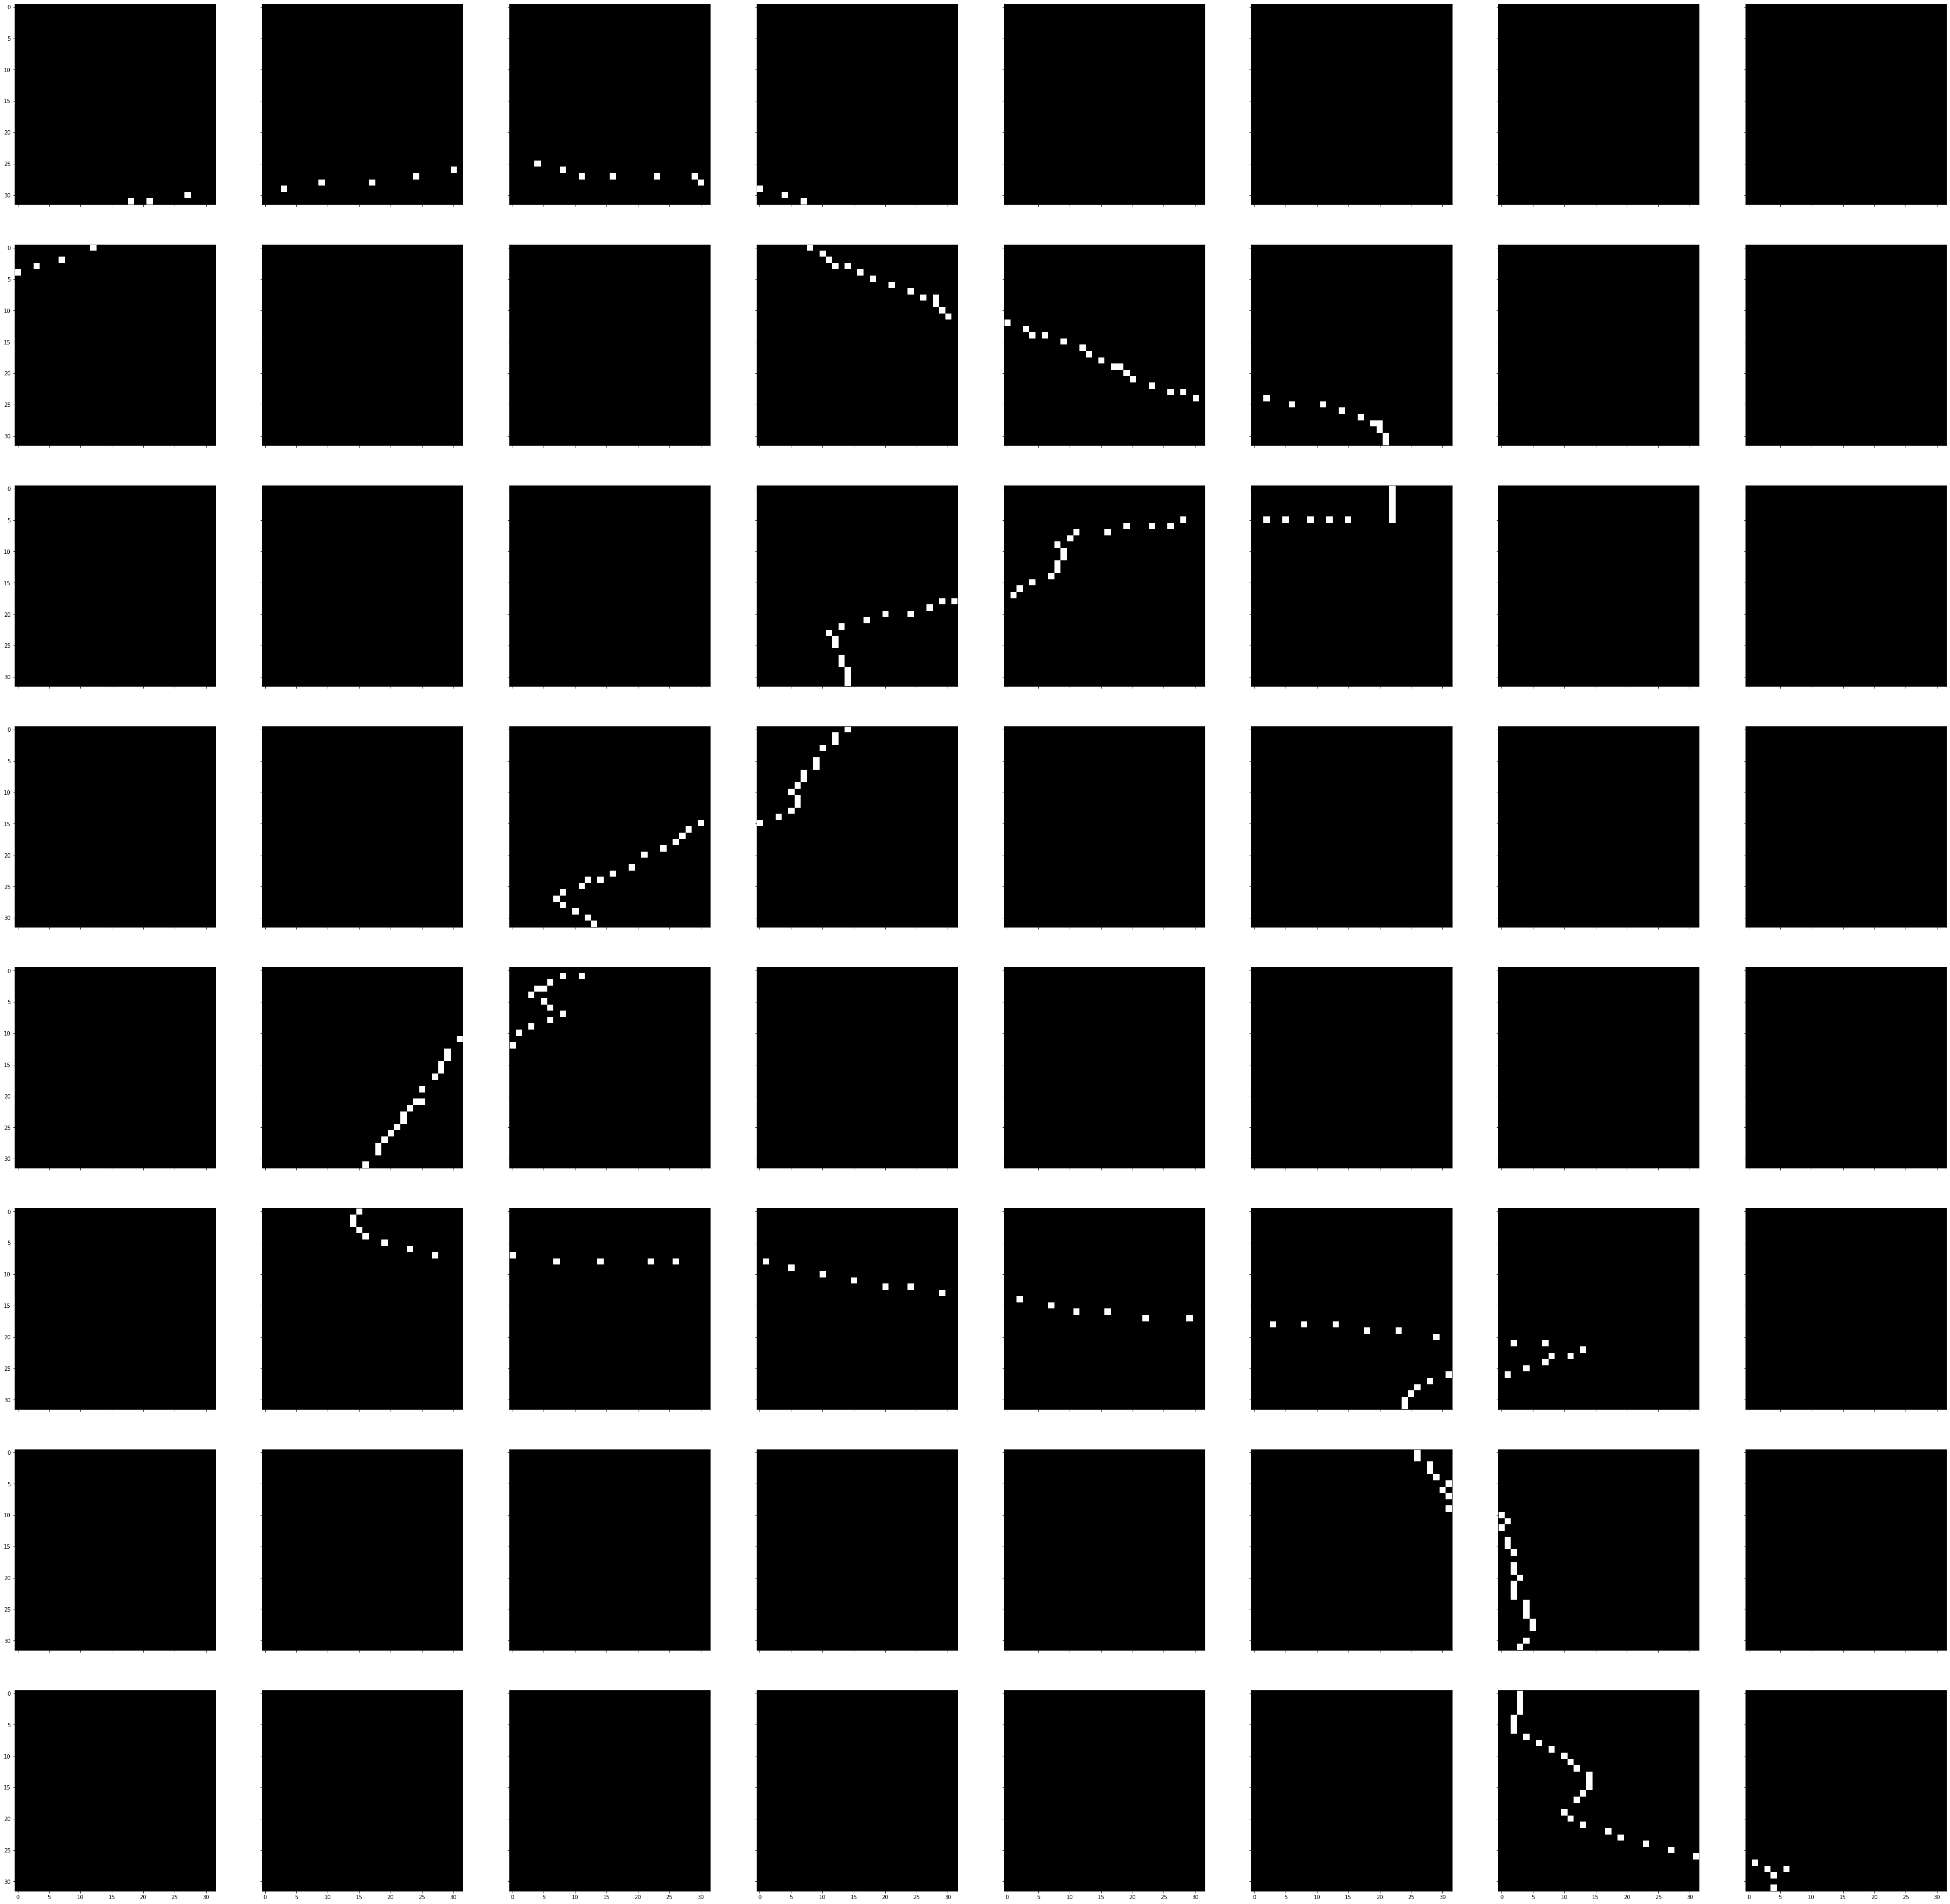

In [ ]:
import matplotlib.pyplot as plt

plt.gray()

row, col = HEIGHT // CROP_HEIGHT, WIDTH // CROP_WIDTH
fig, ax = plt.subplots( row, col, True, True, figsize = ( 64, 64 ) )
for i in range( row * col ):
    ax[i // row][i % col].imshow( cropped_images[i] )
plt.show()

In [ ]:
cropped_images = np.array( cropped_images ).astype( 'float32' ) / 255.
cropped_images = np.reshape( cropped_images, ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) )

In [ ]:
train_size = int( len( cropped_images ) * 0.8 )
X_train, X_test = cropped_images[ : train_size], cropped_images[train_size : ]

In [ ]:
print( X_train.shape, X_test.shape )

(3379, 32, 32, 1) (845, 32, 32, 1)


# Construct AE Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
af, pd = 'relu', 'same' # activation function adn padding value

encode_input = layers.Input( ( CROP_HEIGHT, CROP_WIDTH, 1 ) )
x = layers.Conv2D( 16, ( 9, 9 ), activation = af, padding = pd )( encode_input )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 7, 7 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 8, ( 5, 5 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 8, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()( x )
encode_output = layers.Dense( flatten_size , activation = af )( x )

In [ ]:
encoder = keras.Model( encode_input, encode_output, name = 'Encoder' )
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        1312      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        12560     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 8)           3208      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 8)           0   

In [ ]:
decode_input = layers.Input( ( flatten_size ) )

x = layers.Dense( flatten_size, activation = af )( decode_input )
x = layers.Reshape( feature_map_shape[1:] )( x )

x = layers.Conv2DTranspose( 8, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 8, ( 5, 5 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 7, 7 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 9, 9 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

decode_output = layers.Conv2DTranspose( 1, ( 9, 9 ), activation = af, padding = pd )( x )

In [ ]:
decoder = keras.Model( decode_input, decode_output, name = 'Decoder' )
decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 8)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 2, 2, 8)           584       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 8)           0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 8)           1608      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 8)           0   

In [ ]:
auto_encoder = keras.Model( encode_input, decoder( encoder( encode_input ) ), name = 'Auto_Encoder' )
auto_encoder.summary()

Model: "Auto_Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
Encoder (Functional)         (None, 32)                18720     
_________________________________________________________________
Decoder (Functional)         (None, 32, 32, 1)         31585     
Total params: 50,305
Trainable params: 50,305
Non-trainable params: 0
_________________________________________________________________


# Traing Model

In [ ]:
LAMBDA1, LAMBDA2 = 0.15, 0.85

def SSIM_Loss( y_true, y_pred ):
    ssim = tf.image.ssim( y_true, y_pred, max_val = 1.0, filter_size = 11,
                          filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
    
    return 1 - tf.reduce_mean( ssim )

def Hybrid_Loss( y_true, y_pred ):
    f1 = keras.losses.MAE( y_true, y_pred )
    f2 = SSIM_Loss( y_true, y_pred )

    return LAMBDA1 * f1 + LAMBDA2 * f2

# auto_encoder.compile( 'adam', loss = Hybrid_Loss )
auto_encoder.compile( 'adam', loss = 'mse' )

In [ ]:
EPOCH = 300
BATCH = 128

In [ ]:
history = auto_encoder.fit( X_train, X_train, epochs = EPOCH, batch_size = BATCH )

Epoch 1/300
27/27 [==============================] - 4s 16ms/step - loss: 0.0038
Epoch 2/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0035
Epoch 3/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 5/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 6/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 7/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 8/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0034
Epoch 9/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0033
Epoch 10/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 11/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0032
Epoch 12/300
27/27 [==============================] - 0s 9ms/step - loss: 0.0031
Epoch 13/300
27/27 [================

# Test Model

In [ ]:
os.chdir( RESULT_DIR )

new_result_dir = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Datas"
os.mkdir( new_result_dir )
os.chdir( new_result_dir )

with open( 'Description.txt', 'w' ) as f:
    f.write( EXPERIMENT_DATA['description'] )

In [ ]:
real_test_indexes = [ ]
real_test_data = [ ]

idx = 0
while len( real_test_data ) < 10:
    non_zero = 0
    curr_data = np.reshape( X_test[idx], ( CROP_HEIGHT, CROP_WIDTH ) )
    for i in range( CROP_HEIGHT ):
        for j in range( CROP_WIDTH ):
            if ( curr_data[i][j] > 0 ):
                non_zero += 1
    
    if ( non_zero > 10 ):
        real_test_indexes.append( idx )
        real_test_data.append( curr_data )
    idx += 1

real_test_data = np.reshape( real_test_data, ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) )

## Check Reconstruction

Trajectory_Clusetring_6_Reconstruction(03-22-2021).png


<Figure size 432x288 with 0 Axes>

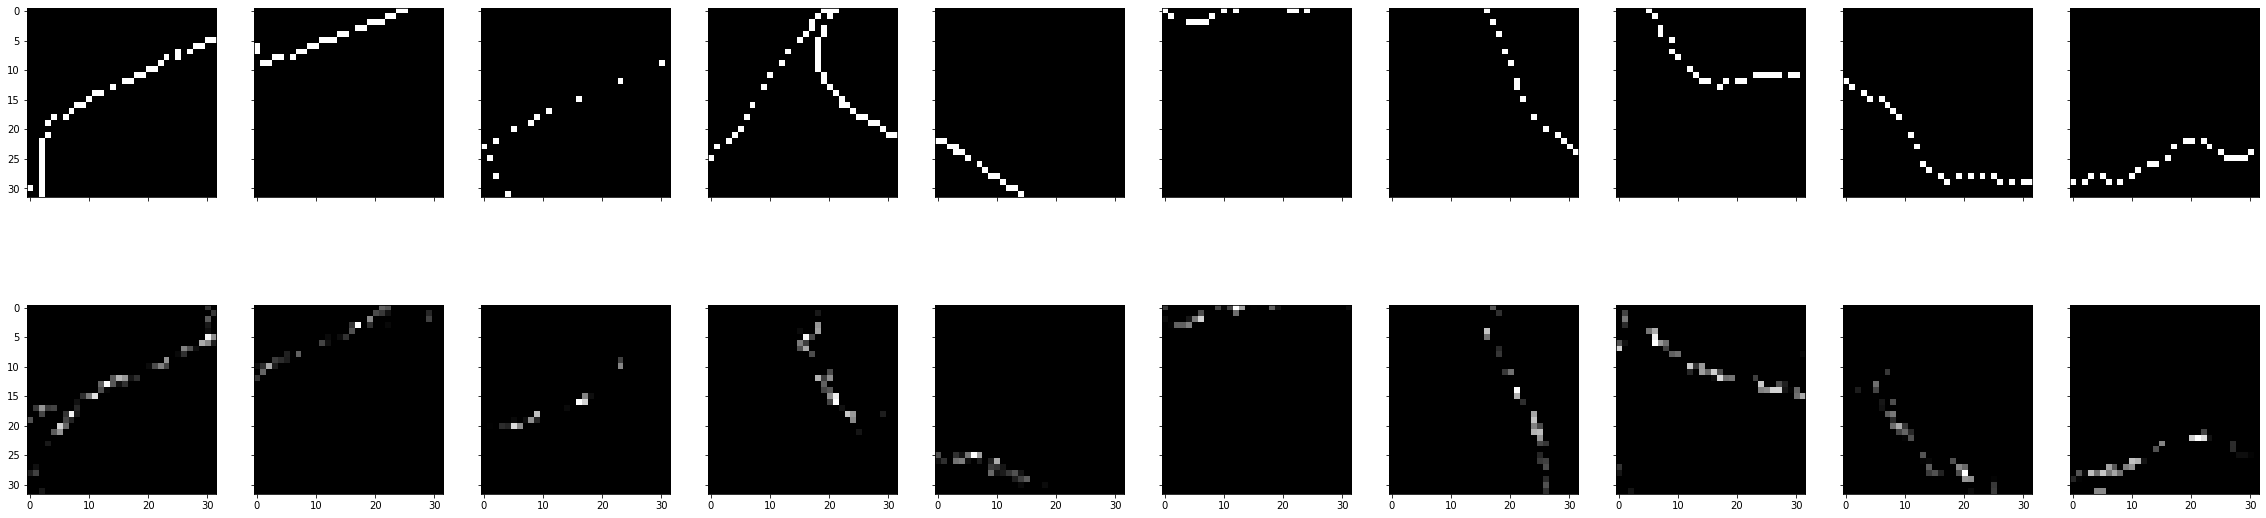

In [ ]:
decoded_img = auto_encoder( X_test )

plt.gray()
n = len( real_test_data )
fig, ax = plt.subplots( 2, n, True, True, figsize = ( 40, 10 ) )
for i, test_idx in zip( range( n ), real_test_indexes ):
    ax[0][i].imshow( X_test[test_idx].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    ax[1][i].imshow( tf.reshape( decoded_img[test_idx], ( CROP_HEIGHT, CROP_WIDTH ) ) )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Reconstruction' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()

## Clustering (HCA)

Trajectory_Clusetring_6_Clustering(03-22-2021).png


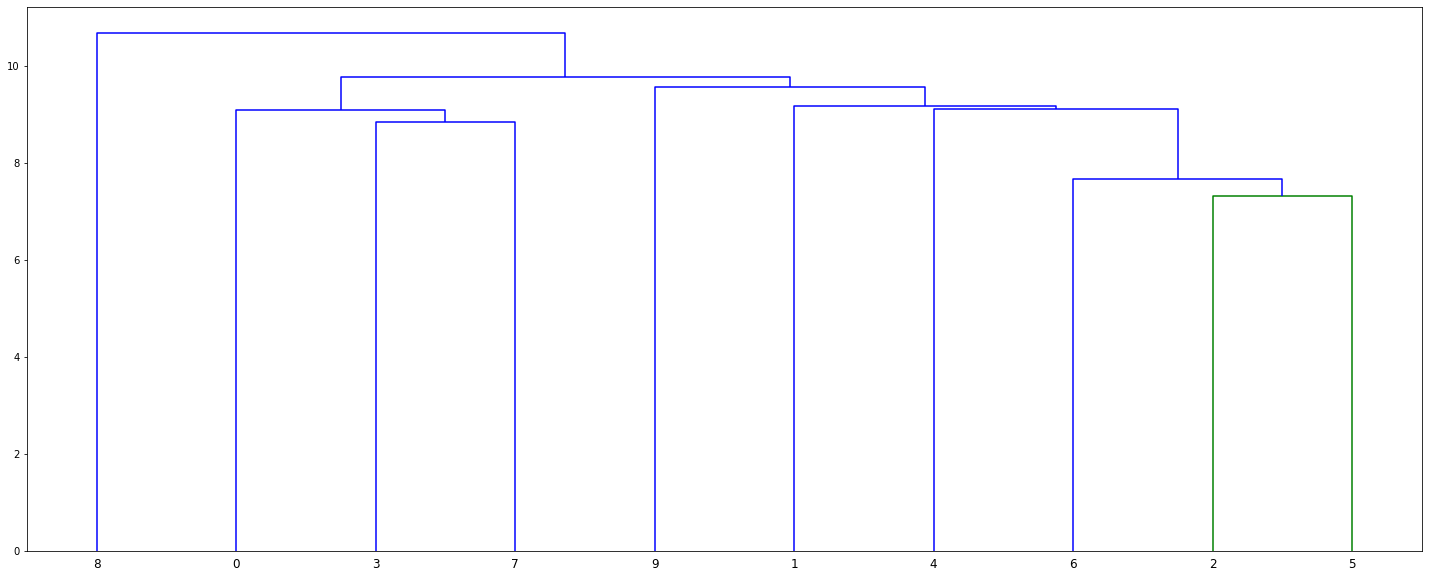

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
low_dimension_data = encoder( real_test_data.reshape( ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) ) )
result = linkage( low_dimension_data )

fig = plt.figure( figsize = ( 25, 10 ) )
dn = dendrogram( result )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Clustering' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()

Trajectory_Clusetring_6_Images(03-22-2021).png


<Figure size 432x288 with 0 Axes>

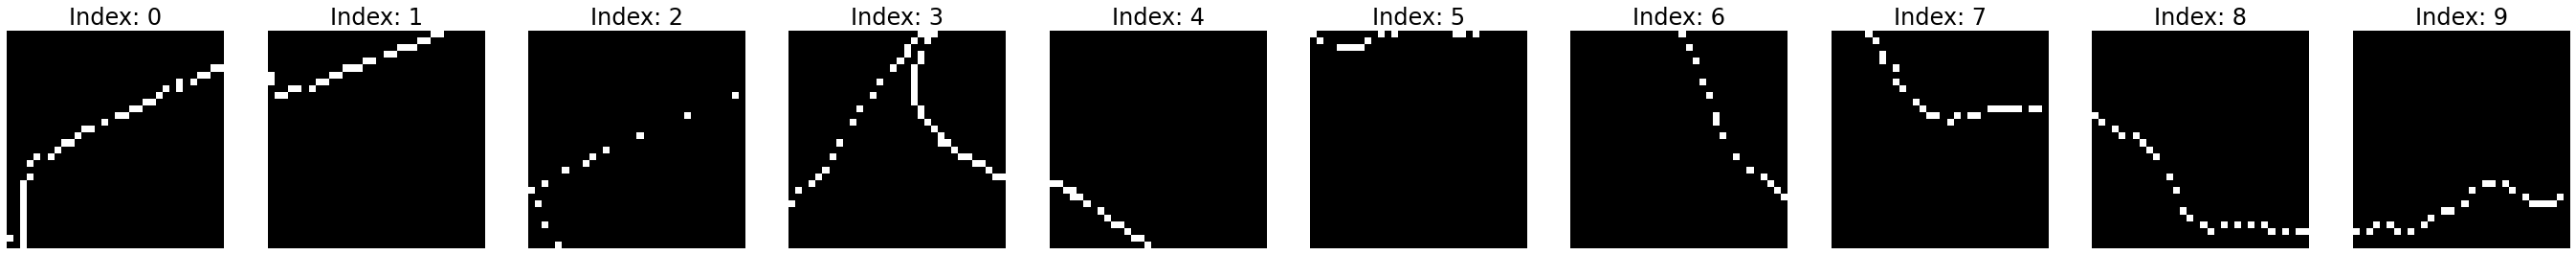

In [ ]:
plt.gray()

n = 10
fig, ax = plt.subplots( 1, n, True, True, figsize = ( 48, 100 ) )
for i in range( n ):
    ax[i].imshow( real_test_data[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    ax[i].set_title( f'Index: {i}', fontsize = 24 )
    ax[i].axis( 'off' )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Images' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 300 )
plt.show()